In [16]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import requests
import json

In [3]:
job_list = ['data scientist', 
            'бизнес аналитик', 
            'web разработчик', 
            'python программист']
max_samples = 400

In [140]:
job_list = ['сварщик', 
            'повар', 
            'преподаватель английского', 
            'секретарь']
max_samples = 400

In [4]:
def get(query, timeout=5, max_retries=5, backoff_factor=0.3):
    """ Выполнить GET-запрос

    :param query: запрос с адресом
    :param timeout: максимальное время ожидания ответа от сервера
    :param max_retries: максимальное число повторных запросов
    :param backoff_factor: коэффициент экспоненциального нарастания задержки
    """
    import time
    import random
    delay = 0
    for i in range(max_retries):
        try:
            response = requests.get(query)
            return response.json()
        except:
            pass
        time.sleep(delay)
        delay = min(delay * backoff_factor, timeout)
        delay += random.random()
    return response

In [19]:
def get_id_page_counts(job_name):
    print(job_name)
    query = "https://api.hh.ru/vacancies?text=" + job_name
    result = get(query)
    return (result['found'], result['pages'])

In [6]:
def get_vacancy_ids(job_name):
    query_data = {
        "search_field": job_name,
        "page": 0
    }
    id_count, page_count = get_id_page_counts(job_name)
    id_list = []
    while query_data['page']<page_count:
        query = "https://api.hh.ru/vacancies?text={search_field}&page={page}".format(**query_data)
        result = get(query)
        query_data["page"] += 1
        for i in range(len(result['items'])):
            id_list.append(result['items'][i]['id'])
    return id_list

In [7]:
def parse_append(raw_data, json_data):
    if not json_data:
        json_data={
                'id': [],
                'name': [],
                'schedule': [],
                'employment':[],
                'experience':[],
                'salary_min': [],
                'salary_max': [],
                'currency': []
    }
    json_data['id'].append(raw_data['id'])
    json_data['name'].append(raw_data['name'])
    json_data['schedule'].append(raw_data['schedule']['id'])
    json_data['employment'].append(raw_data['employment']['id'])
    json_data['experience'].append(raw_data['experience']['id'])
    if raw_data['salary']:
        if raw_data['salary']['from'] == None: 
            json_data['salary_min'].append(raw_data['salary']['to'])
        else:
            json_data['salary_min'].append(raw_data['salary']['from'])
        if raw_data['salary']['to'] == None: 
            json_data['salary_max'].append(raw_data['salary']['from'])
        else:
            json_data['salary_max'].append(raw_data['salary']['to'])
        json_data['currency'].append(raw_data['salary']['currency'])
    else:
        json_data['salary_min'].append(None)
        json_data['salary_max'].append(None)
        json_data['currency'].append(None)   
    return json_data

In [30]:
def parse_append(raw_data, json_data):
    try:
        if not json_data:
            json_data={
                    'id': [],
                    'name': [],
                    'schedule': [],
                    'employment':[],
                    'experience':[],
                    'salary_min': [],
                    'salary_max': [],
                    'currency': []
        }
        json_data['id'].append(raw_data['id'])
        json_data['name'].append(raw_data['name'])
        json_data['schedule'].append(raw_data['schedule']['id'])
        json_data['employment'].append(raw_data['employment']['id'])
        json_data['experience'].append(raw_data['experience']['id'])
        if raw_data['salary']:
            if raw_data['salary']['from'] == None: 
                json_data['salary_min'].append(raw_data['salary']['to'])
            else:
                json_data['salary_min'].append(raw_data['salary']['from'])
            if raw_data['salary']['to'] == None: 
                json_data['salary_max'].append(raw_data['salary']['from'])
            else:
                json_data['salary_max'].append(raw_data['salary']['to'])
            json_data['currency'].append(raw_data['salary']['currency'])
        else:
            json_data['salary_min'].append(None)
            json_data['salary_max'].append(None)
            json_data['currency'].append(None)   
        return json_data
    except:
        print(raw_data)

In [8]:
def ids_to_data(id_list):
    job_json = {}
    for i in range(len(id_list)):
        query = "https://api.hh.ru/vacancies/" + id_list[i]
        job_json = parse_append(get(query), job_json)
    return job_json        

In [9]:
def get_job_data(job_name, count=None):
    id_list = get_vacancy_ids(job_name)
    if count:
        return ids_to_data(id_list[:count])
    return ids_to_data(id_list)

In [133]:
def normalize_currency(job_entry):
    if job_entry.currency == 'USD':
        job_entry.currency = 'RUR'
        job_entry.salary *= 75
    if job_entry.currency == 'EUR':
        job_entry.currency = 'RUR'
        job_entry.salary *= 90
    return job_entry

In [129]:
def normalize_salary(job_df):
    job_df.insert(loc=4, column='salary', value=((job_df['salary_min']+job_df['salary_max'])/2))
    job_df = job_df.apply(normalize_currency, axis=1)
    return job_df.drop(columns=['salary_min', 'salary_max', 'currency'])

In [142]:
job_df_list = {}
for i in range(len(job_list)):
    job_df_list[job_list[i]] = {}

In [143]:
print(job_df_list.keys())

dict_keys(['сварщик', 'повар', 'преподаватель английского', 'секретарь'])


In [145]:
for job in job_df_list.keys():
    job_df_list[job] = pd.DataFrame(get_job_data(job, count = max_samples))

сварщик
повар
преподаватель английского
секретарь


In [146]:
for job in job_df_list.keys():
    if job == list(job_df_list.keys())[0]:
        job_df_full = job_df_list[job].head(max_samples)
        job_df_full.insert(loc=2, column='job_type', value=job)
    else:
        job_df_full = job_df_full.append(job_df_list[job])
        job_df_full['job_type'] = job_df_full['job_type'].fillna(job)

In [147]:
job_df_full.head()

,id,name,job_type,schedule,employment,experience,salary_min,salary_max,currency
0,41130189,Сварщик-универсал,сварщик,flyInFlyOut,full,between3And6,240000.0,300000.0,RUR
1,41412846,Сварщик-универсал,сварщик,flyInFlyOut,full,between3And6,240000.0,300000.0,RUR
2,41596650,Сварщик,сварщик,fullDay,full,between1And3,70000.0,90000.0,RUR
3,41453792,Сварщик на полуавтомат,сварщик,fullDay,full,between1And3,100000.0,100000.0,RUR
4,41537136,Электрогазосварщик (универсал),сварщик,flyInFlyOut,full,between3And6,130000.0,150000.0,RUR


In [148]:
job_df_full = normalize_salary(job_df_full)
job_df_full.head()

,id,name,job_type,schedule,salary,employment,experience
0,41130189,Сварщик-универсал,сварщик,flyInFlyOut,270000.0,full,between3And6
1,41412846,Сварщик-универсал,сварщик,flyInFlyOut,270000.0,full,between3And6
2,41596650,Сварщик,сварщик,fullDay,80000.0,full,between1And3
3,41453792,Сварщик на полуавтомат,сварщик,fullDay,100000.0,full,between1And3
4,41537136,Электрогазосварщик (универсал),сварщик,flyInFlyOut,140000.0,full,between3And6


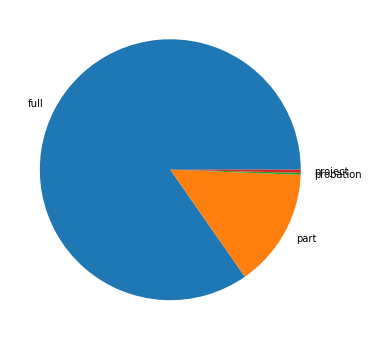

In [149]:
job_df_class = job_df_full.groupby('employment').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")
plt.show()

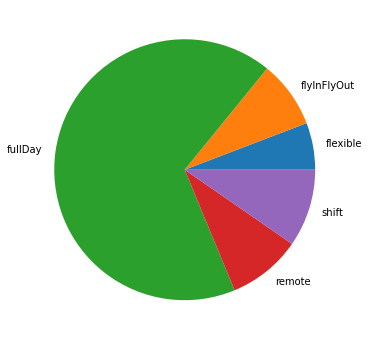

In [150]:
job_df_class = job_df_full.groupby('schedule').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")
plt.show()

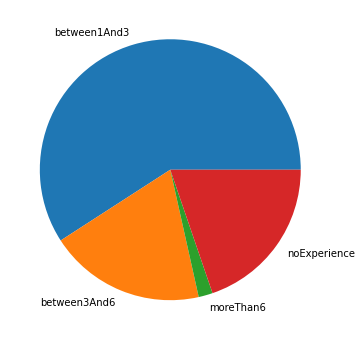

In [151]:
job_df_class = job_df_full.groupby('experience').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")
plt.show()

In [160]:
np.unique(job_df_full[x_var]).tolist()

array([0.  , 0.75, 1.5 , 2.25, 3.  ])

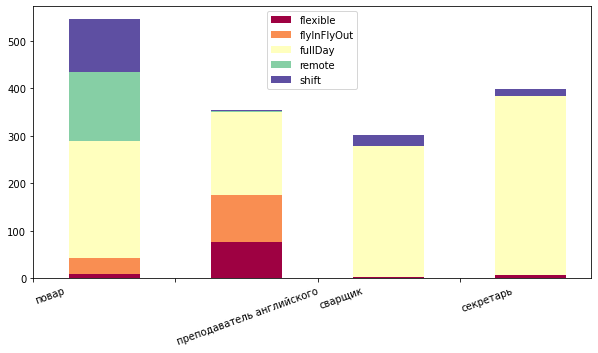

In [165]:
x_var = 'job_type'
groupby_var = 'schedule'
job_df_agg = job_df_full.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [job_df_full[x_var].astype('category').cat.codes.values.tolist() for i, job_df_full in job_df_agg]
plt.figure(figsize=(10,5))
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, job_df_full[x_var].unique().__len__(), color=colors[:len(vals)], rwidth=0.5, stacked=True, density=False)
plt.legend({group:col for group, col in zip(np.unique(job_df_full[groupby_var]).tolist(), colors[:len(vals)])})
plt.xticks(bins[:-1], np.unique(job_df_full[x_var]).tolist(), rotation=20, horizontalalignment='left')
plt.show()

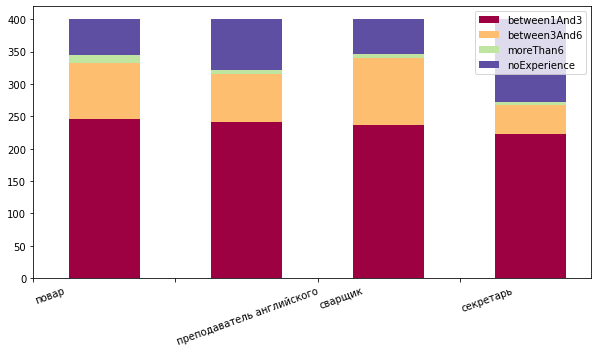

In [167]:
x_var = 'job_type'
groupby_var = 'experience'
job_df_agg = job_df_full.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [job_df_full[x_var].astype('category').cat.codes.values.tolist() for i, job_df_full in job_df_agg]
plt.figure(figsize=(10,5))
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, job_df_full[x_var].unique().__len__(), color=colors[:len(vals)], rwidth=0.5, stacked=True, density=False)
plt.legend({group:col for group, col in zip(np.unique(job_df_full[groupby_var]).tolist(), colors[:len(vals)])})
plt.xticks(bins[:-1], np.unique(job_df_full[x_var]).tolist(), rotation=20, horizontalalignment='left')
plt.show()

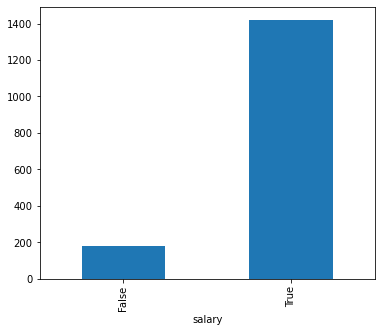

In [154]:
# Entries with/without salary
job_df_class = job_df_full.groupby(job_df_full['salary']>0).size()
job_df_class.plot(kind='bar', figsize=(6, 5))
plt.show()

In [155]:
salary_df = job_df_full[job_df_full['salary']>0]

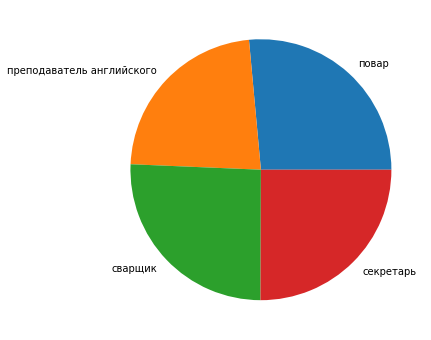

In [156]:
# Entries with salary per job
job_df_class = salary_df.groupby('job_type').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")
plt.show()

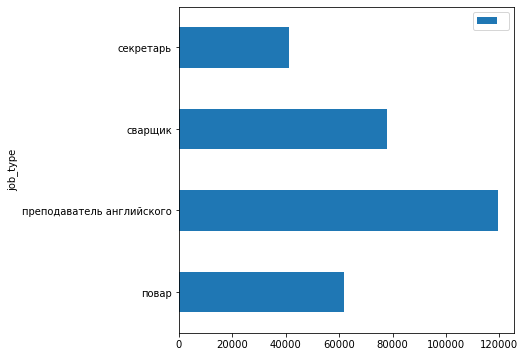

In [157]:
# Average wage per job type
job_df_class = salary_df.groupby('job_type').sum()
job_df_class['salary'] /= salary_df.groupby('job_type').size()
job_df_class.plot(kind='barh', y='salary', figsize=(6, 6), label="")
plt.show()

In [ ]:
# зарплата в зависимости от опыта
# вводится свой опыт, неподходящие фильтруются
# литературные источники (в отчет) визуализации и анализа трудоустройства (ручного и автоматическо)
# исследования трудоустройства ручные проводились (12345), но недостатком этих исследований является то что они проводились вручную, и при любых изменениях на рынке труда (напр. ковид) резулдьтаты исследований становятся неактуальными, а их обновление требует большого количество дополнительных временных и человеческих ресурсов.
# автоматисечкие исследования тоже проводились, но:
#    -код закрытый
#    -пользоваться уже нельзя
#    -плохая визуализация
#    -нельзя перенести на другие сферы
# встроенные ресурсы на сайтах поиска работы тоже не позволяют обрабатывать большие объемы данных
# результат - наглядный и адаптирующийся